In [3]:
# Load Packages

library(readr)
library(plyr)
library(dplyr)
library(ggplot2)
library(corrplot)
library(scales)
library(ggrepel)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


corrplot 0.84 loaded


Attaching package: ‘scales’


The following object is masked from ‘package:readr’:

    col_factor




In [4]:
# Import CSV and create dataframe using readr

df = read_csv("raw_data/NYPD_Arrests_Data__Historic_.csv")


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  ARREST_KEY = col_double(),
  ARREST_DATE = col_character(),
  PD_CD = col_double(),
  PD_DESC = col_character(),
  KY_CD = col_double(),
  OFNS_DESC = col_character(),
  LAW_CODE = col_character(),
  LAW_CAT_CD = col_character(),
  ARREST_BORO = col_character(),
  ARREST_PRECINCT = col_double(),
  JURISDICTION_CODE = col_double(),
  AGE_GROUP = col_character(),
  PERP_SEX = col_character(),
  PERP_RACE = col_character(),
  X_COORD_CD = col_double(),
  Y_COORD_CD = col_double(),
  Latitude = col_double(),
  Longitude = col_double(),
  Lon_Lat = col_character()
)




In [6]:
# View first few rows of df

head(df)

ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
144026181,06/26/2015,639,AGGRAVATED HARASSMENT 2,361,OFF. AGNST PUB ORD SENSBLTY & RGHTS TO PRIV,PL 2403002,M,Q,102,0,45-64,M,WHITE HISPANIC,1031076,193779,40.69844,-73.83113,POINT (-73.83112953899997 40.69843969400005)
144507595,07/14/2015,969,"TRAFFIC,UNCLASSIFIED INFRACTION",881,OTHER TRAFFIC INFRACTION,VTL051101A,M,M,10,3,25-44,M,WHITE HISPANIC,984791,209846,40.74266,-73.99805,POINT (-73.99804910799998 40.74266360800004)
144565062,07/16/2015,101,ASSAULT 3,344,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,K,90,0,18-24,F,WHITE HISPANIC,994026,195548,40.70341,-73.96474,POINT (-73.96474295699994 40.70341366900004)
144500188,07/14/2015,879,"ADM.CODE,UNCLASSIFIED VIOLATION",675,ADMINISTRATIVE CODE,AC 010125B,V,Q,103,0,25-44,M,WHITE HISPANIC,1037132,196129,40.70486,-73.80927,POINT (-73.809270971 40.70485576300007)
144216044,07/03/2015,478,"THEFT OF SERVICES, UNCLASSIFIED",343,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,M,10,1,18-24,M,WHITE HISPANIC,984602,210686,40.74497,-73.99873,POINT (-73.99873112099993 40.74496920800005)
144925030,07/30/2015,339,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",341,PETIT LARCENY,PL 1552500,M,B,45,0,18-24,M,BLACK,1030990,255310,40.86733,-73.83101,POINT (-73.83101160699994 40.86732605200007)


In [32]:
# Remove all rows with NAs in any column
df = na.omit(df)

In [33]:
# Change data types
df$ARREST_DATE = as.Date(df$ARREST_DATE, format = '%m/%d/%Y')

In [34]:
# Create new columns for Year, Month, Day
df$ARREST_YEAR = format(as.Date(df$ARREST_DATE, format = "%m/%d/%Y"), "%Y")
df$ARREST_MONTH = format(as.Date(df$ARREST_DATE, format = "%m/%d/%Y"), "%m")
df$ARREST_DAY = format(as.Date(df$ARREST_DATE, format = "%m/%d/%Y"), "%d")

In [35]:
# Change data types for Year, Month, Day
df$ARREST_YEAR = as.integer(df$ARREST_YEAR)
df$ARREST_MONTH = as.integer(df$ARREST_MONTH)
df$ARREST_DAY = as.integer(df$ARREST_DAY)

In [36]:
# Order df by ARREST_KEY descending
df = df[rev( order(df$ARREST_KEY) ),]

In [37]:
# There are 85 different values of OFNS_DESC
length(unique(df$OFNS_DESC))

[1] 85

In [38]:
# Reducing crime categories for simpler reporting
# THEFT_FRAUD
THEFT = c("BURGLARY","PETIT LARCENY","OFFENSES INVOLVING FRAUD","THEFT OF SERVICES","POSSESSION OF STOLEN PROPERTY 5","THEFT-FRAUD",
          "OTHER OFFENSES RELATED TO THEF","FRAUDULENT ACCOSTING","ROBBERY","GRAND LARCENY OF MOTOR VEHICLE",
          "POSSESSION OF STOLEN PROPERTY","GRAND LARCENY","FORGERY","BURGLAR'S TOOLS","FRAUDS","OTHER OFFENSES RELATED TO THEFT",
          "JOSTLING","CRIMINAL TRESPASS")
df$CATEGORY[df$OFNS_DESC %in% THEFT] = "THEFT & FRAUD"

# DRUGS
DRUGS = c("DANGEROUS DRUGS","LOITERING FOR DRUG PURPOSES","UNDER THE INFLUENCE, DRUGS")
df$CATEGORY[df$OFNS_DESC %in% DRUGS] = "DRUGS"

# WEAPONS
WEAPONS = c("DANGEROUS WEAPONS","UNLAWFUL POSS. WEAP. ON SCHOOL","UNLAWFUL POSS. WEAP. ON SCHOOL GROUNDS")
df$CATEGORY[df$OFNS_DESC %in% WEAPONS] = "WEAPONS"

# ASSAULT
ASSAULT = c("FELONY ASSAULT","ASSAULT 3 & RELATED OFFENSES")
df$CATEGORY[df$OFNS_DESC %in% ASSAULT] = "ASSAULT"

# SEXUAL_ASSAULT
SEXUAL_ASSAULT = c("RAPE","SEX CRIMES","FORCIBLE TOUCHING")
df$CATEGORY[df$OFNS_DESC %in% SEXUAL_ASSAULT] = "SEXUAL ASSAULT"

# TRAFFIC
TRAFFIC = c("INTOXICATED & IMPAIRED DRIVING","VEHICLE AND TRAFFIC LAWS","MOVING INFRACTIONS","PARKING OFFENSES",
            "INTOXICATED/IMPAIRED DRIVING","OTHER TRAFFIC INFRACTION", "UNAUTHORIZED USE OF A VEHICLE 3 (UUV)",
            "UNAUTHORIZED USE OF A VEHICLE")
df$CATEGORY[df$OFNS_DESC %in% TRAFFIC] = "TRAFFIC"

# MURDER
MURDER = c("MURDER & NON-NEGL. MANSLAUGHTE", "MURDER & NON-NEGL. MANSLAUGHTER", "HOMICIDE-NEGLIGENT,UNCLASSIFIED", 
           "HOMICIDE-NEGLIGENT-VEHICLE","HOMICIDE-NEGLIGENT,UNCLASSIFIE")
df$CATEGORY[df$OFNS_DESC %in% MURDER] = "MURDER"

# CHILDREN
CHILDREN = c("KIDNAPPING", "CHILD ABANDONMENT/NON SUPPORT 1", "KIDNAPPING & RELATED OFFENSES", "OFFENSES RELATED TO CHILDREN",
             "CHILD ABANDONMENT/NON SUPPORT")
df$CATEGORY[df$OFNS_DESC %in% CHILDREN] = "CHILDREN"

# OTHER
ALL_CAT = c(THEFT, DRUGS, WEAPONS, ASSAULT, SEXUAL_ASSAULT, MURDER, CHILDREN, TRAFFIC)
df$CATEGORY[!df$OFNS_DESC %in% ALL_CAT] = "OTHER"

In [39]:
# CATEGORY column will contain only 9 distinct values
unique(df$CATEGORY)

[1] "OTHER"          "ASSAULT"        "THEFT & FRAUD"  "TRAFFIC"       
[5] "WEAPONS"        "DRUGS"          "SEXUAL ASSAULT" "MURDER"        
[9] "CHILDREN"

In [40]:
# Drop unnecessary columns
df = within(df, rm(PD_CD, KY_CD, LAW_CODE, JURISDICTION_CODE))

Warning message in rm(PD_CD, KY_CD, LAW_CODE, JURISDICTION_CODE):
“object 'PD_CD' not found”
Warning message in rm(PD_CD, KY_CD, LAW_CODE, JURISDICTION_CODE):
“object 'KY_CD' not found”
Warning message in rm(PD_CD, KY_CD, LAW_CODE, JURISDICTION_CODE):
“object 'LAW_CODE' not found”
Warning message in rm(PD_CD, KY_CD, LAW_CODE, JURISDICTION_CODE):
“object 'JURISDICTION_CODE' not found”


`summarise()` ungrouping output (override with `.groups` argument)



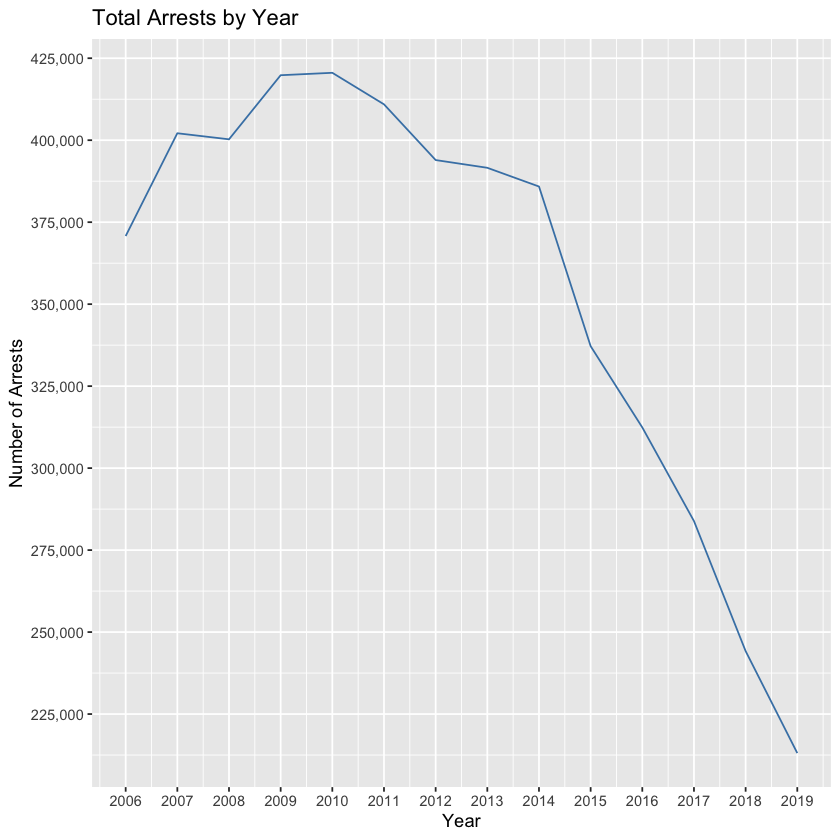

In [42]:
# Plot arrests by year using dplyr
df_arrests_year = df %>%
  group_by(ARREST_YEAR) %>%
  summarize(total_arrests = n())
df_arrests_year %>% 
  ggplot( aes(x = ARREST_YEAR, y = total_arrests) ) + 
  geom_line(color = "steel blue") +
  ggtitle("Total Arrests by Year") +
  xlab("Year") +
  ylab("Number of Arrests") +
  scale_y_continuous(breaks = scales::breaks_extended(n=10), labels=comma) +
  scale_x_continuous(breaks = seq(min(df_arrests_year$ARREST_YEAR),max(df_arrests_year$ARREST_YEAR),1))

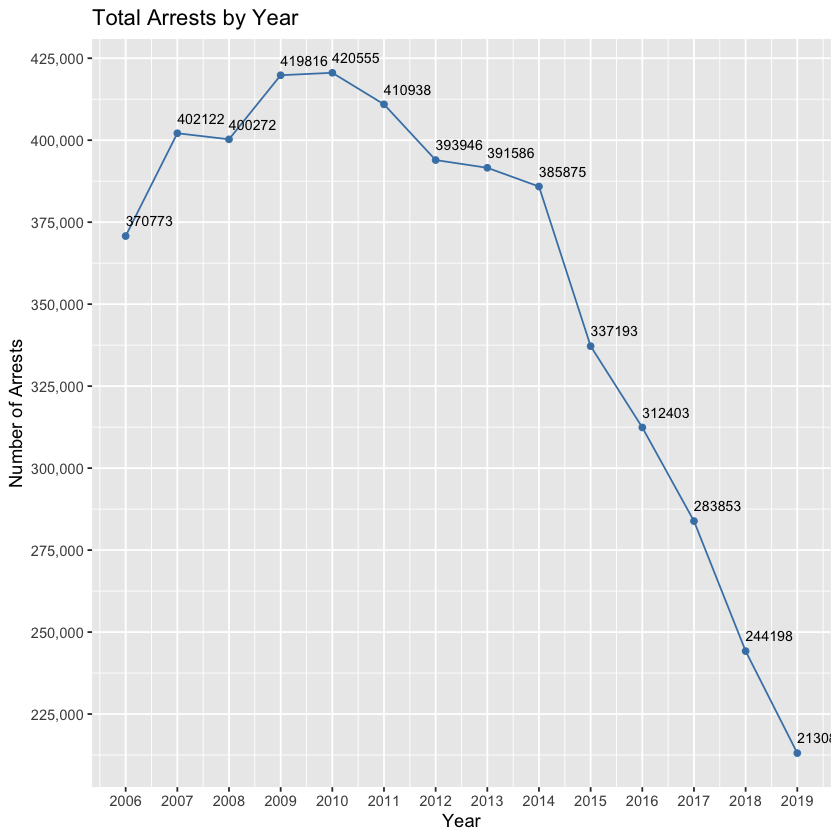

In [43]:
# We can also add labels to the graph
df_arrests_year %>% 
  ggplot( aes(x = ARREST_YEAR, y = total_arrests, label=total_arrests) ) + 
  geom_line(color = "steel blue") +
  ggtitle("Total Arrests by Year") +
  xlab("Year") +
  ylab("Number of Arrests") +
  scale_y_continuous(breaks = scales::breaks_extended(n=10), labels=comma) +
  #scale_y_continuous(breaks = df_arrests_year$total_arrests) +
  scale_x_continuous(breaks = seq(min(df_arrests_year$ARREST_YEAR),max(df_arrests_year$ARREST_YEAR),1)) +
  geom_text(hjust=0, vjust=-1, size=3) +
  geom_point(color='steel blue')

Warning message:
“Removed 1 rows containing missing values (geom_text).”


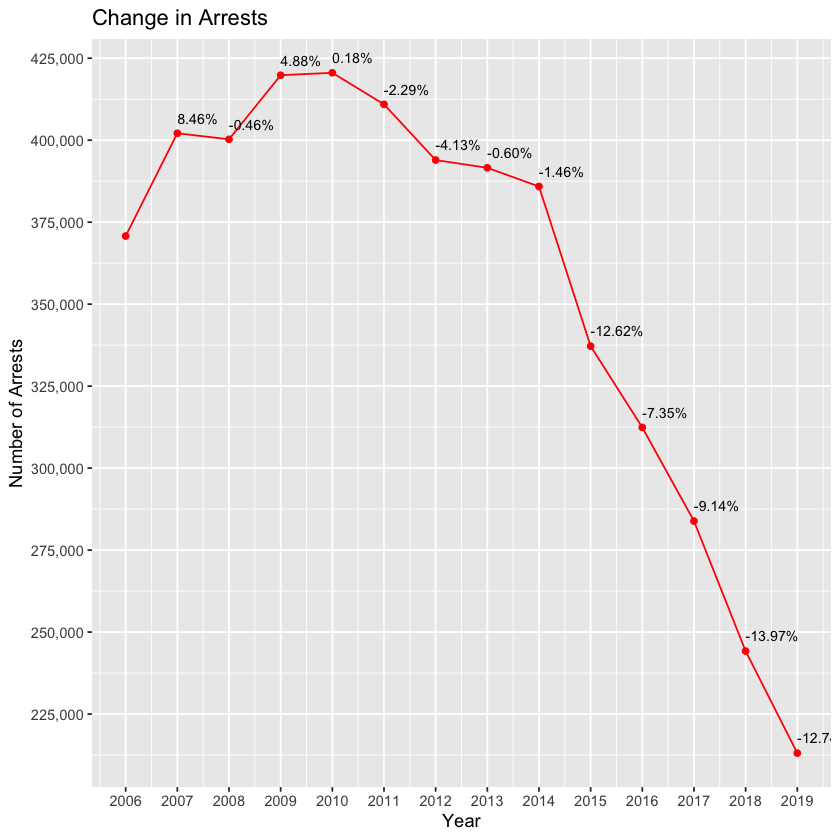

In [44]:
# Add percentage change
df_arrests_year_pc = mutate(df_arrests_year, change=(total_arrests/lag(total_arrests))-1)

df_arrests_year_pc %>% 
  ggplot( aes(x = ARREST_YEAR, y = total_arrests, label=scales::percent(change)) ) + 
  geom_line(color = "red") +
  ggtitle("Change in Arrests") +
  xlab("Year") +
  ylab("Number of Arrests") +
  scale_y_continuous(breaks = scales::breaks_extended(n=10), labels=comma) +
  scale_x_continuous(breaks = seq( min(df_arrests_year_pc$ARREST_YEAR), max(df_arrests_year_pc$ARREST_YEAR),1)) +
  geom_text(hjust=0, vjust=-1, size=3) +
  geom_point(color = 'red')

`summarise()` ungrouping output (override with `.groups` argument)



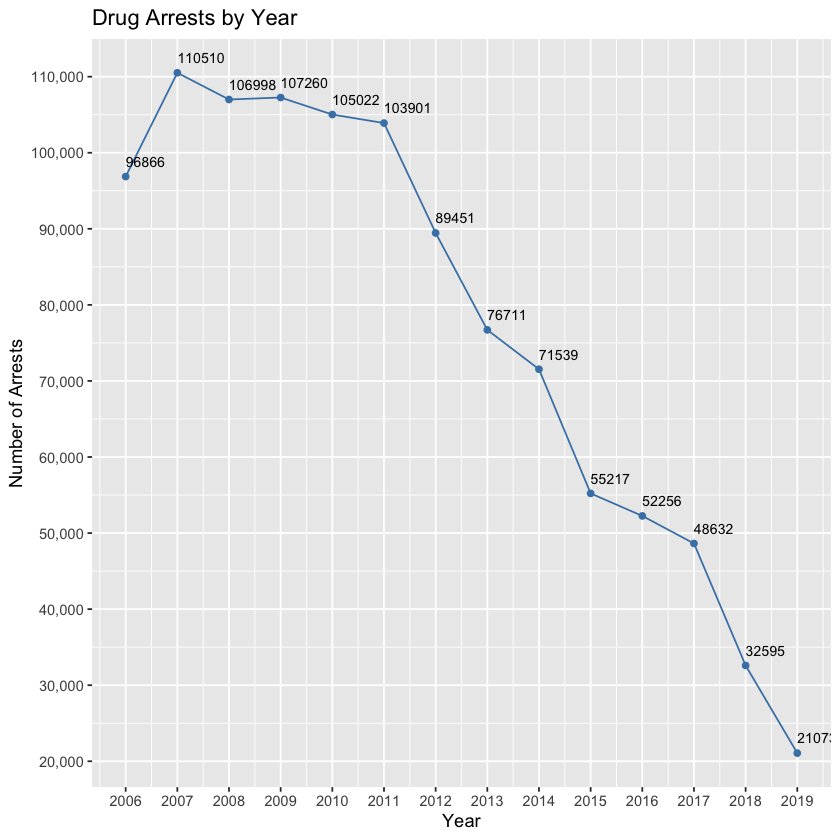

In [47]:
# Plot drug arrests for all years
df_arrests_drugs = df %>%
  filter(CATEGORY == 'DRUGS') %>%
  group_by(ARREST_YEAR) %>%
  summarize(total_arrests = n())
  
df_arrests_drugs %>%
  ggplot( aes(x=ARREST_YEAR, y=total_arrests, label=total_arrests) ) +
  geom_line(color = 'steel blue') +
  ggtitle("Drug Arrests by Year") +
  xlab("Year") +
  ylab("Number of Arrests") +
  scale_y_continuous(breaks = scales::breaks_extended(n=10), labels=comma) +
  scale_x_continuous(breaks = seq( min(df_arrests_drugs$ARREST_YEAR), max(df_arrests_drugs$ARREST_YEAR), 1)) +
  geom_text(hjust=0, vjust=-1, size=3) +
  geom_point(color='steel blue')

Warning message:
“Removed 1 rows containing missing values (geom_text).”


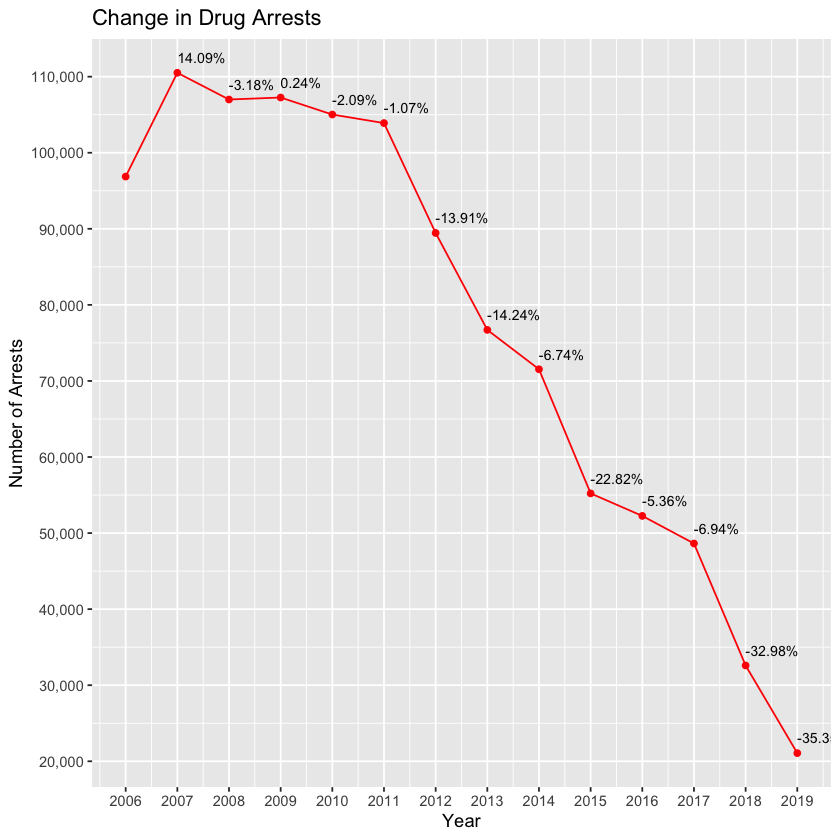

In [48]:
# Plot drug arrests percent change
df_arrests_drugs_pc = mutate(df_arrests_drugs, change=(total_arrests/lag(total_arrests))-1)

df_arrests_drugs_pc %>% 
  ggplot( aes(x=ARREST_YEAR, y=total_arrests, label=scales::percent(change))) +
  geom_line(color = 'red') +
  ggtitle("Change in Drug Arrests") +
  xlab("Year") +
  ylab("Number of Arrests") +
  scale_y_continuous(breaks = scales::breaks_extended(n=10), labels = comma) +
  scale_x_continuous(breaks = seq( min(df_arrests_drugs_pc$ARREST_YEAR), max(df_arrests_drugs_pc$total_arrests), 1)) +
  geom_text(hjust=0, vjust=-1, size=3) +
  geom_point(color='red')

`summarise()` regrouping output by 'ARREST_YEAR' (override with `.groups` argument)



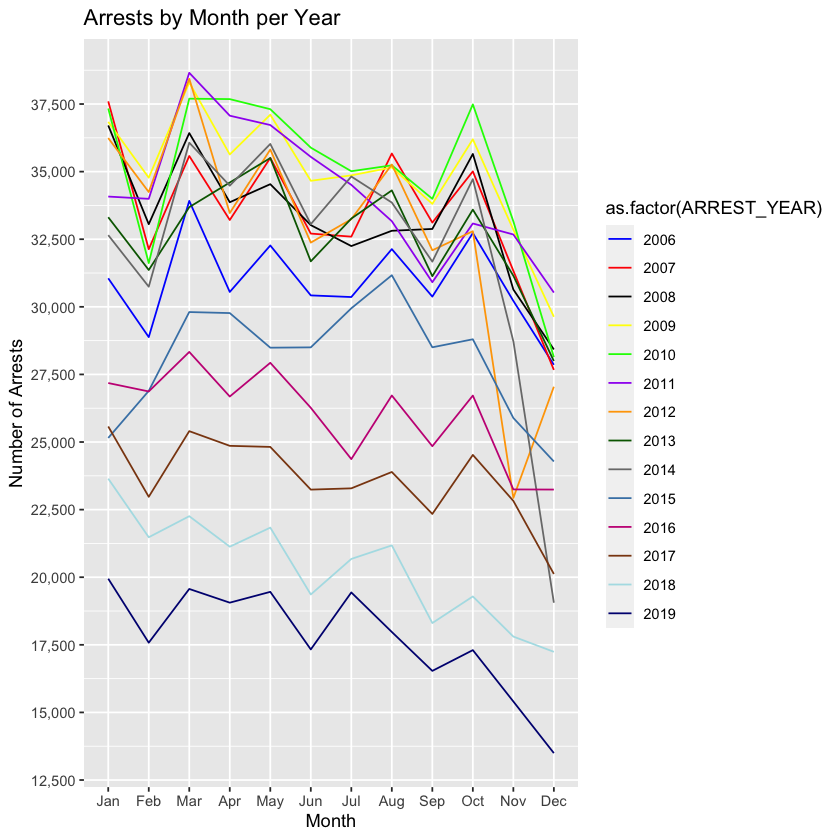

In [49]:
# Plot total arrests with line for each year
df_arrests_month_year = df %>%
  group_by(ARREST_YEAR, ARREST_MONTH) %>%
  summarize(total_arrests = n())

df_arrests_month_year = df_arrests_month_year %>%
  mutate(ARREST_MONTH = factor(month.abb[months], levels = month.abb))

df_arrests_month_year %>%
  ggplot(aes(x=ARREST_MONTH, y=total_arrests, group=ARREST_YEAR, color=as.factor(ARREST_YEAR))) +
  geom_line() +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  #geom_text() +
  ggtitle('Arrests by Month per Year') +
  xlab('Month') +
  ylab('Number of Arrests') +
  scale_color_manual(values=c('blue','red','black','yellow','green','purple','orange','dark green','gray48','steel blue',
                              'mediumvioletred','saddlebrown','powderblue','navy'))

`summarise()` ungrouping output (override with `.groups` argument)



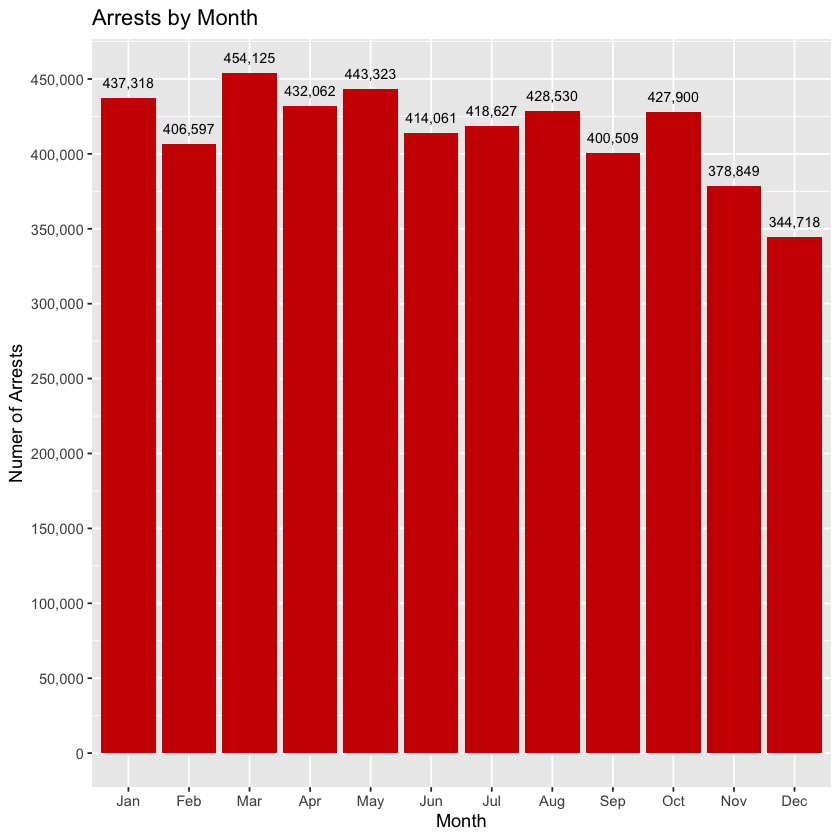

In [50]:
# Arrests by Month
df_arrests_month_name = df %>%
  group_by(ARREST_MONTH) %>%
  summarize(total_arrests = n())

df_arrests_month_name= df_arrests_month %>% 
  mutate(ARREST_MONTH = factor(month.abb[months], levels = month.abb))

df_arrests_month_name %>%
  ggplot(aes(x=ARREST_MONTH, y=total_arrests), label=total_arrests) +
  geom_bar(stat='identity', fill='red3') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  ggtitle('Arrests by Month') +
  ylab('Numer of Arrests') +
  xlab('Month')

`summarise()` ungrouping output (override with `.groups` argument)



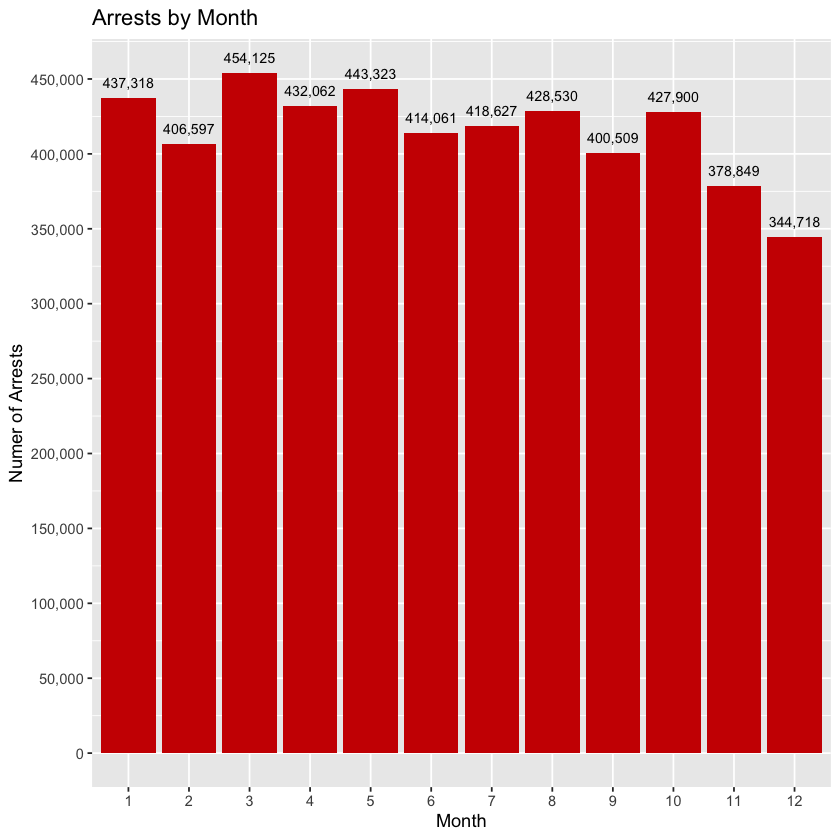

In [51]:
# or we can use the number of the month

df_arrests_month = df %>%
  group_by(ARREST_MONTH) %>%
  summarize(total_arrests = n())

df_arrests_month = df_arrests_month %>%
  mutate(ARREST_MONTH = factor(ARREST_MONTH))

df_arrests_month %>%
  ggplot(aes(x=ARREST_MONTH, y=total_arrests), label=total_arrests) +
  geom_bar(stat='identity', fill='red3') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  ggtitle('Arrests by Month') +
  ylab('Numer of Arrests') +
  xlab('Month') 

`summarise()` ungrouping output (override with `.groups` argument)



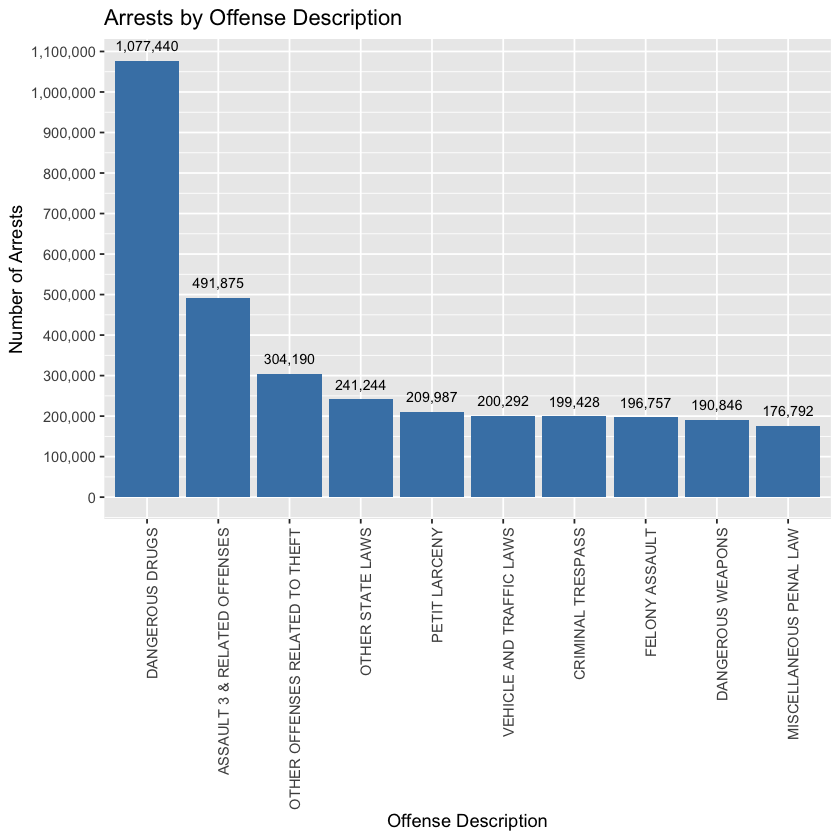

In [52]:
# Top 10 crimes by OFNS_DESC
df_top_10 = df %>%
  group_by(OFNS_DESC) %>%
  summarize(total_arrests = n())
# sort desc
df_top_10 = top_n(df_top_10, 10, total_arrests) %>%
  arrange(desc(total_arrests))
df_top_10 %>%
  ggplot(aes(x=OFNS_DESC, y=total_arrests, label=total_arrests)) +
  geom_bar(stat='identity', fill='steel blue') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  theme(axis.text.x=element_text(angle=90,hjust=1)) +
  aes(x = reorder(OFNS_DESC, -total_arrests)) +
  ggtitle('Arrests by Offense Description') +
  xlab('Offense Description') +
  ylab('Number of Arrests')

`summarise()` ungrouping output (override with `.groups` argument)



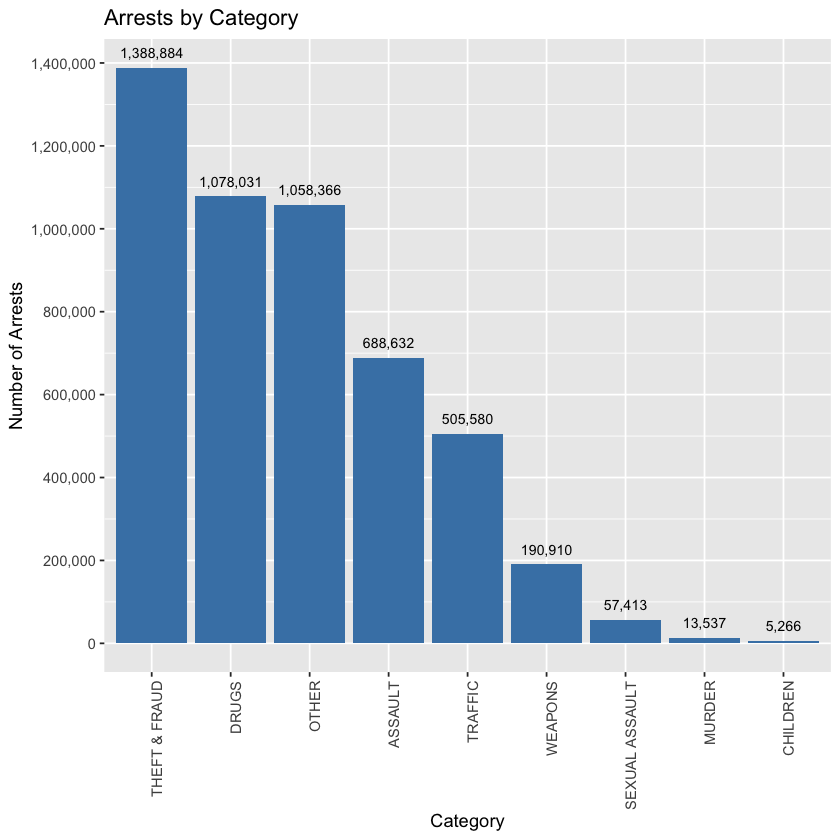

In [53]:
# Top crimes by CATEGORY
df_top_cat = df %>%
  group_by(CATEGORY) %>%
  summarize(total_arrests = n())
df_top_cat = top_n(df_top_cat,length(unique(df$CATEGORY)),total_arrests) %>%
  arrange(desc(total_arrests))

df_top_cat %>%
  ggplot(aes(x=CATEGORY, y=total_arrests, label=total_arrests)) +
  geom_bar(stat='identity', fill='steel blue') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  theme(axis.text.x=element_text(angle=90,hjust=1)) +
  aes(x=reorder(CATEGORY, -total_arrests)) +
  ggtitle('Arrests by Category') +
  xlab('Category') +
  ylab('Number of Arrests')

`summarise()` ungrouping output (override with `.groups` argument)



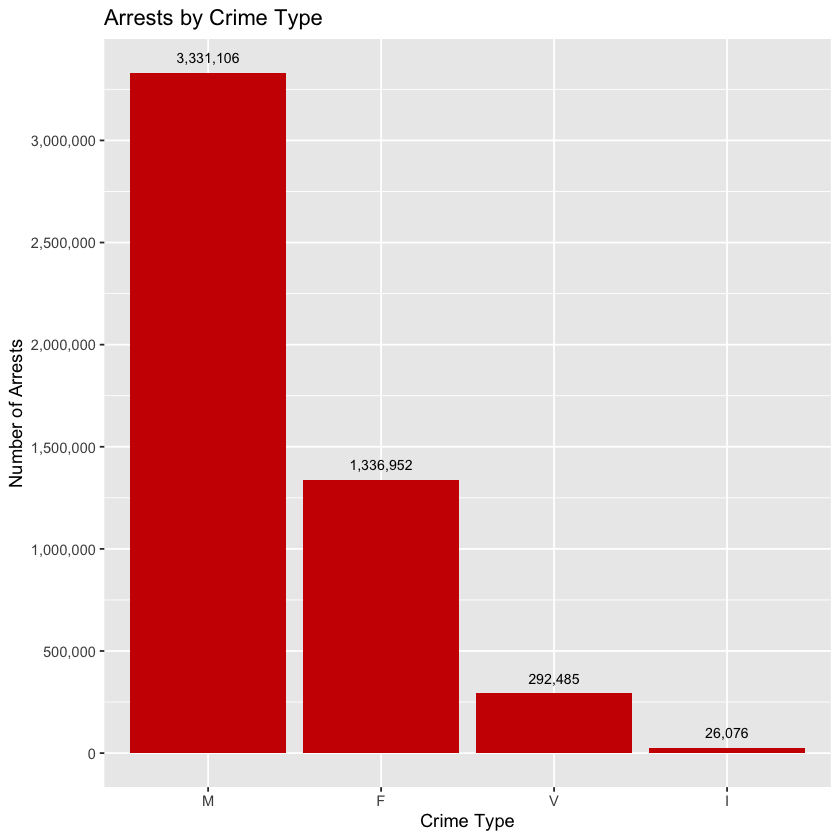

In [54]:
# Crimes by Misdemeanors, Felonies, Violations, Infractions
df_crime_type = df %>%
  group_by(LAW_CAT_CD) %>%
  summarize(total_arrests = n())

df_crime_type %>%
  ggplot(aes(x=LAW_CAT_CD, y=total_arrests), label=total_arrests) +
  geom_bar(stat='identity', fill='red3') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  aes(x=reorder(LAW_CAT_CD, -total_arrests)) +
  ggtitle('Arrests by Crime Type') +
  xlab('Crime Type') +
  ylab('Number of Arrests')

`summarise()` ungrouping output (override with `.groups` argument)



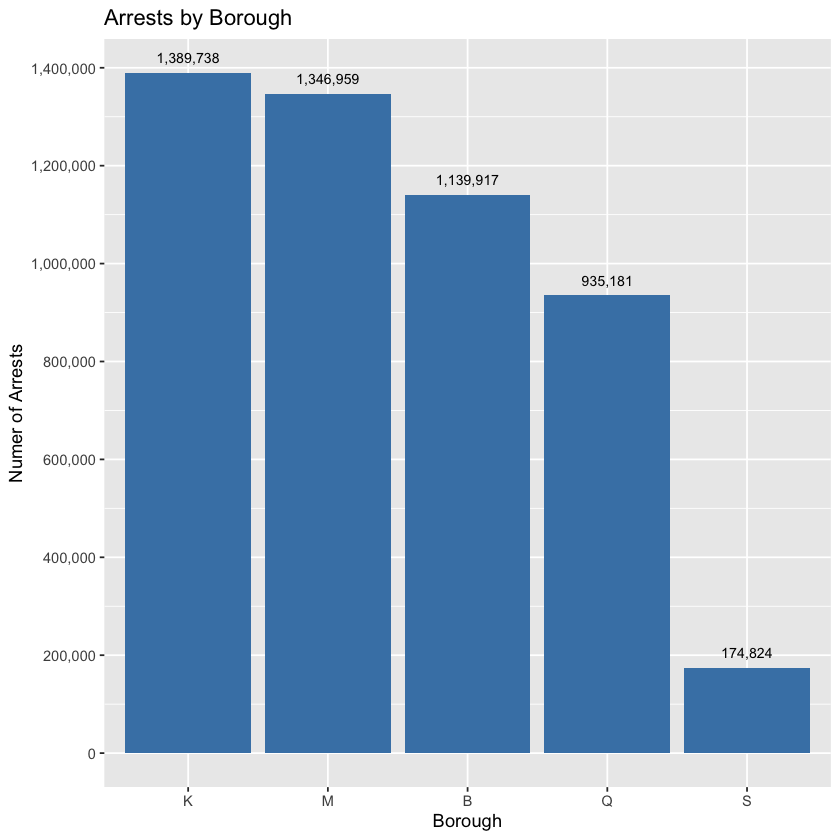

In [55]:
# Arrests by Borough
df_arrests_boro = df %>%
  group_by(ARREST_BORO) %>%
  summarize(total_arrests = n())

df_arrests_boro %>% 
  ggplot(aes(x=ARREST_BORO, y=total_arrests), label=total_arrests) +
  geom_bar(stat='identity', fill='steel blue') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  aes(x=reorder(ARREST_BORO, -total_arrests), label= 'Total') +
  ggtitle('Arrests by Borough') +
  ylab('Numer of Arrests') +
  xlab('Borough')

[1] "18-24"   "25-44"   "45-64"   "<18"     "65+"     "UNKNOWN"

[1] "18-24"   "25-44"   "45-64"   "<18"     "65+"     "UNKNOWN"

`summarise()` ungrouping output (override with `.groups` argument)



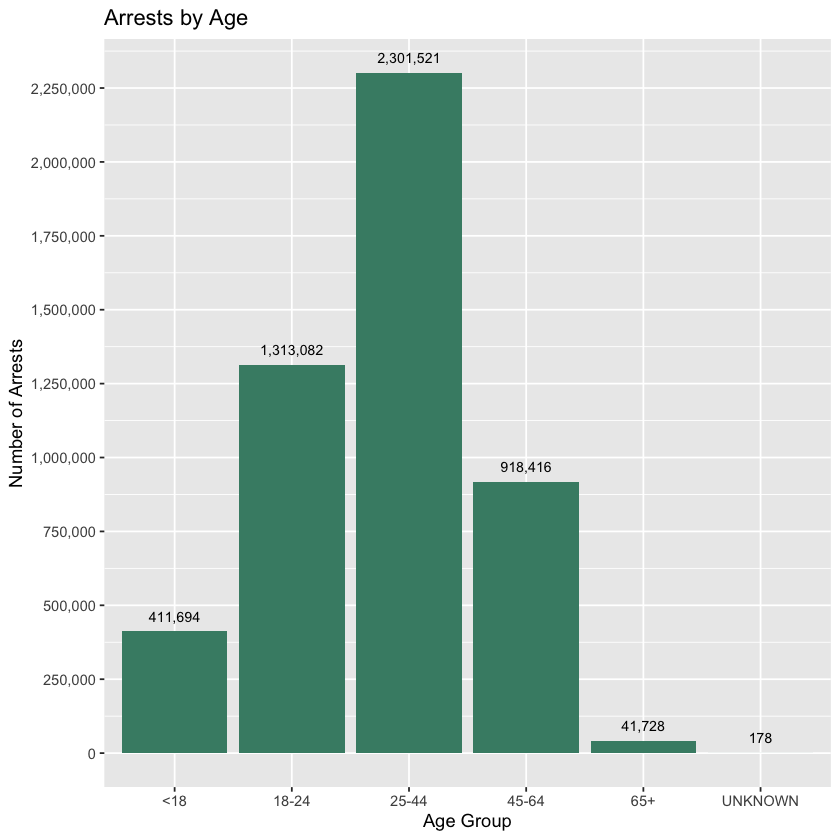

In [57]:
# Plot total arrests by age

# There are 91 distinct values in the AGE_GROUP column
unique(df$AGE_GROUP)

# Let's replace the values don't make sense with "UNKNOWN"

good_ages = c('<18', '18-24', '25-44', '45-64', '65+')
df$AGE_GROUP[!df$AGE_GROUP %in% good_ages] = 'UNKNOWN'

# Now there are only 6 distinct values in AGE_GROUP
unique(df$AGE_GROUP)

# We must filter only the results that make sense

df_arrests_age = df %>%
  group_by(AGE_GROUP) %>%
  summarize(total_arrests=n())

df_arrests_age %>%
  ggplot(aes(x=AGE_GROUP, y=total_arrests), label=total_arrets) +
  geom_bar(stat='identity', fill='aquamarine4') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  ggtitle('Arrests by Age') +
  xlab('Age Group') +
  ylab('Number of Arrests')

`summarise()` ungrouping output (override with `.groups` argument)



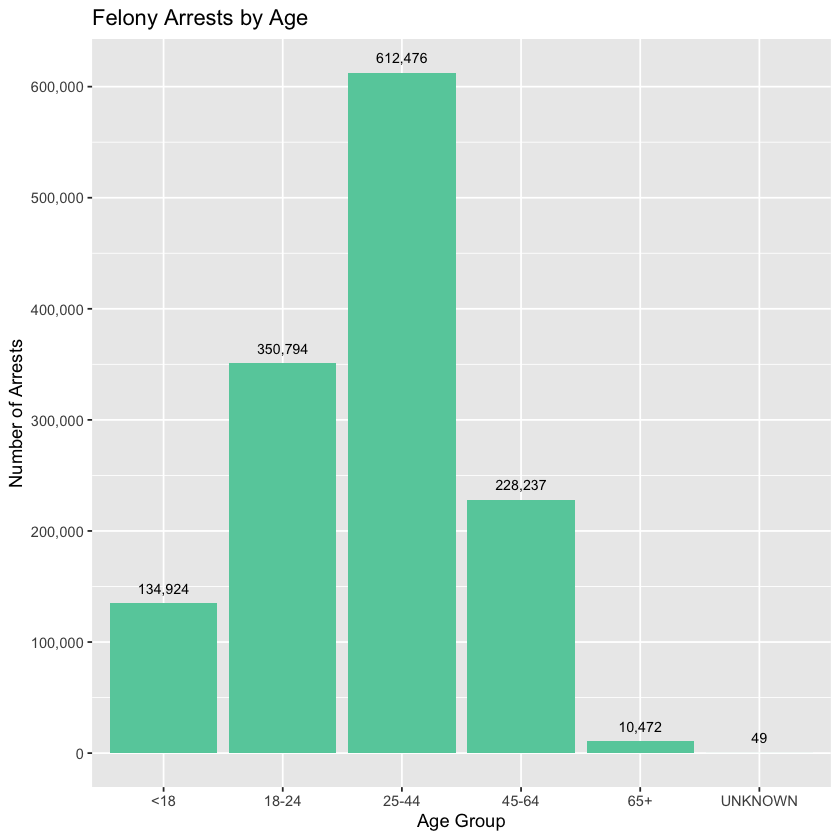

In [59]:
# Plot arrests by age for felonies

df_arrests_age_fel = df %>%
  filter(LAW_CAT_CD == 'F') %>%
  group_by(AGE_GROUP) %>%
  summarize(total_arrests=n())

df_arrests_age_fel %>%
  ggplot(aes(x=AGE_GROUP, y=total_arrests), label=total_arrets) +
  geom_bar(stat='identity', fill='aquamarine3') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  ggtitle('Felony Arrests by Age') +
  xlab('Age Group') +
  ylab('Number of Arrests')

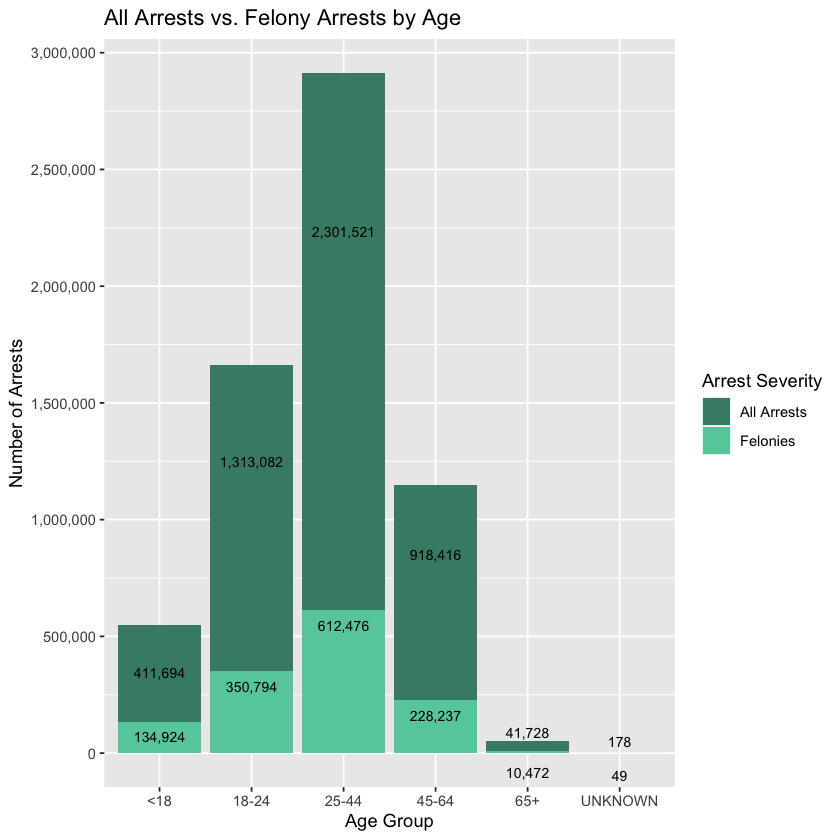

In [61]:
# Plot all arrests by age & arrests for felonies by age on same chart
df_arrests_age_comb = dplyr::bind_rows(df_arrests_age, df_arrests_age_fel, .id='id')
df_arrests_age_comb %>%
  ggplot(aes(x=AGE_GROUP, y=total_arrests, fill=id, label=total_arrests)) +
  geom_bar(stat='identity') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  #geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  ggtitle('All Arrests vs. Felony Arrests by Age') +
  scale_fill_manual(labels=c('All Arrests','Felonies'), values=c('aquamarine4','aquamarine3')) +
  labs(title='All Arrests vs. Felony Arrests by Age', x='Age Group', y='Number of Arrests', fill='Arrest Severity') +
  geom_text_repel(vjust=2, direction='y', segment.color='transparent', aes(label=comma(total_arrests)), size=3)

`summarise()` ungrouping output (override with `.groups` argument)



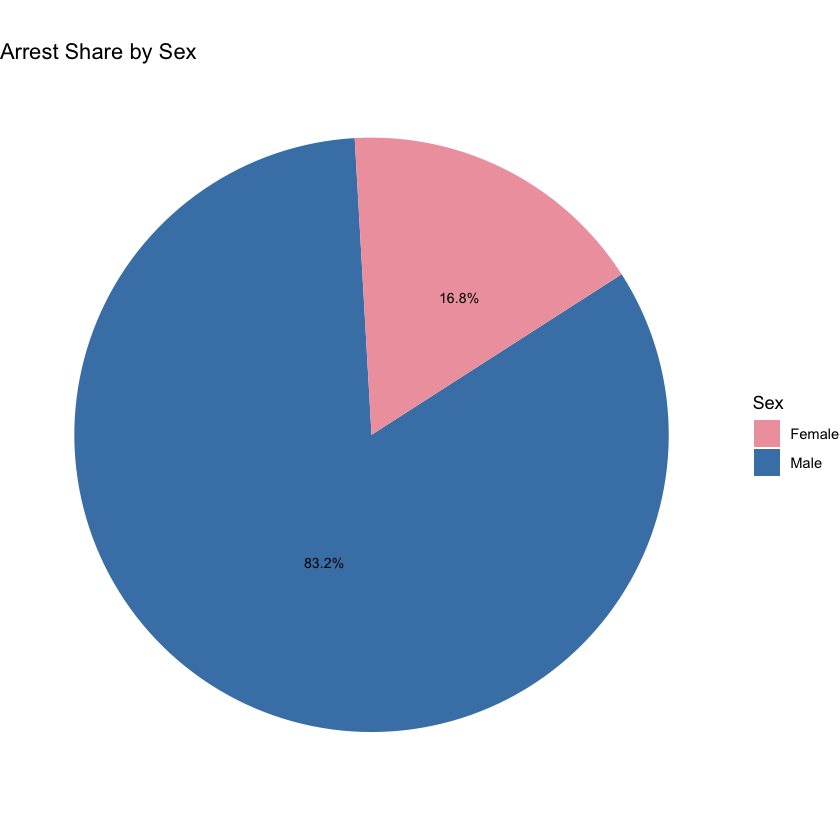

In [66]:
# Pie chart by sex
df_sex = df %>%
  group_by(PERP_SEX) %>%
  summarize(total_arrests = n()) %>%
  arrange(desc(total_arrests))

df_sex = df_sex %>%
  mutate(prop=total_arrests/sum(total_arrests), prop=scales::percent(prop,.10))

df_sex %>%
  ggplot(aes(x='', y=total_arrests, label=prop, fill=PERP_SEX)) +
  geom_bar(stat='identity') +
  coord_polar('y', start=1) +
  theme_void() +
  scale_fill_manual(labels=c('Female','Male'), values=c('lightpink2','steel blue')) +
  geom_text(hjust=0, vjust=0, size=3, aes(label=prop), color="black", position=position_stack(vjust=.5)) +
  labs(title='Arrest Share by Sex', fill='Sex')

`summarise()` ungrouping output (override with `.groups` argument)



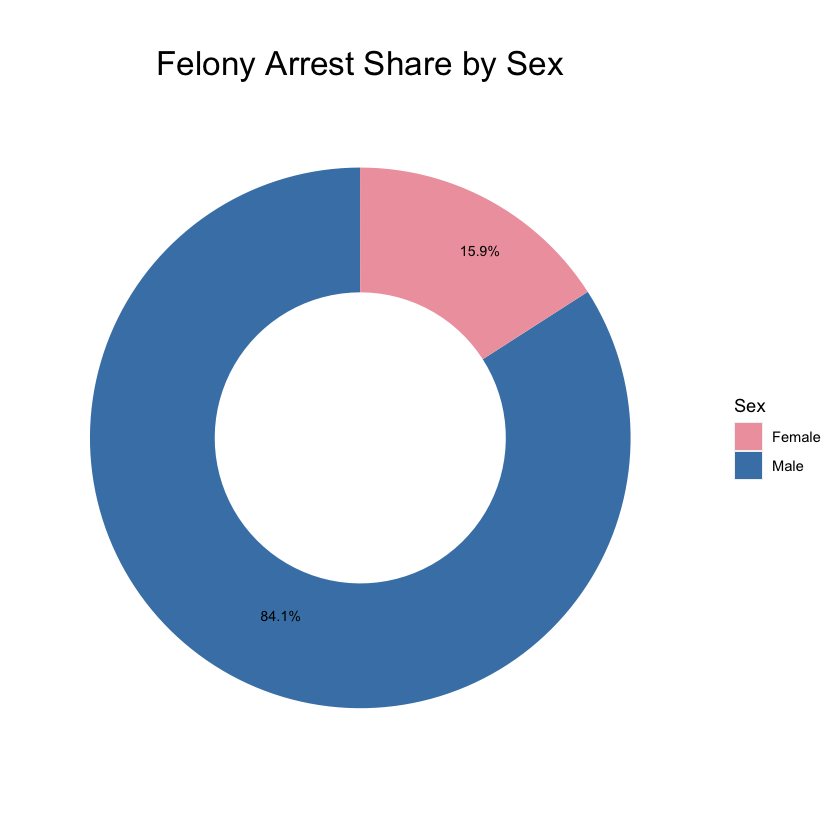

In [65]:
# Doughnut chart for felony arrests by sex
df_sex_fel = df %>%
  filter(LAW_CAT_CD=='F') %>%
  group_by(PERP_SEX) %>%
  summarize(total_arrests = n()) %>%
  arrange(desc(total_arrests))

df_sex_fel = df_sex_fel %>%
  mutate(prop=total_arrests/sum(total_arrests), prop=scales::percent(prop,.10))

df_sex_fel %>%
  ggplot(aes(x=2, y=total_arrests, label=prop, fill=PERP_SEX)) +
  geom_bar(stat='identity') +
  coord_polar(theta='y', start=1) +
  #theme_void() +
  scale_fill_manual(labels=c('Female','Male'), values=c('lightpink2','steel blue')) +
  geom_text(hjust=0, vjust=0, size=3, aes(label=prop), color="black", position=position_stack(vjust=.5)) +
  labs(title='Felony Arrest Share by Sex', fill='Sex') +
  xlim(0.5,2.5) +
  theme(panel.background=element_blank(),
        axis.line=element_blank(),
        axis.text=element_blank(),
        axis.ticks=element_blank(),
        axis.title=element_blank(), 
        plot.title=element_text(hjust=0.5, size=20))